# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
- Triaxial Angular velocity from the gyroscope
- A 561-feature vector with time and frequency domain variables
- The activity label

More information about the features are available on the website linked above.


In [ ]:
# !pip install seaborn
# !pip install pandas
# !pip install numpy
# !pip install  matplotlib
# !pip install scikit-learn

In [1]:
# Supress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Import libraries
import seaborn as sns, pandas as pd, numpy as np

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts.
* Determine if the floating point values need to be scaled.
* Determine the breakdown of each activity.
* Encode the activity label as an integer.


In [3]:
### BEGIN SOLUTION
# Load dataset
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

The data columns are all floats except for the activity label.


In [4]:
# Count the number of columns of each datatype
data.dtypes.value_counts()

,count
float64,561
object,1


In [5]:
# Check for some columns' datatype
data.dtypes.tail()

,0
"angle(tBodyGyroJerkMean,gravityMean)",float64
"angle(X,gravityMean)",float64
"angle(Y,gravityMean)",float64
"angle(Z,gravityMean)",float64
Activity,object


The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [6]:
# Check min value of all columns except the last "Activity"
data.iloc[:, :-1].min().value_counts()

,count
-1.0,561


In [7]:
# Check max value of all columns except the last "Activity"
data.iloc[:, :-1].max().value_counts()

,count
1.0,561


Examine the breakdown of activities; they are relatively balanced.


In [8]:
# Count number of different values in column Activity
data.Activity.value_counts()

,count
Activity,
LAYING,1944
STANDING,1906
SITTING,1777
WALKING,1722
WALKING_UPSTAIRS,1544
WALKING_DOWNSTAIRS,1406


Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [9]:
# Using Label Encoding to encode values in column Activity
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

,Activity
7264,3
6973,2
1141,5
8578,2
2885,2


## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values.
* Identify those that are most correlated (either positively or negatively).


In [11]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan

# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

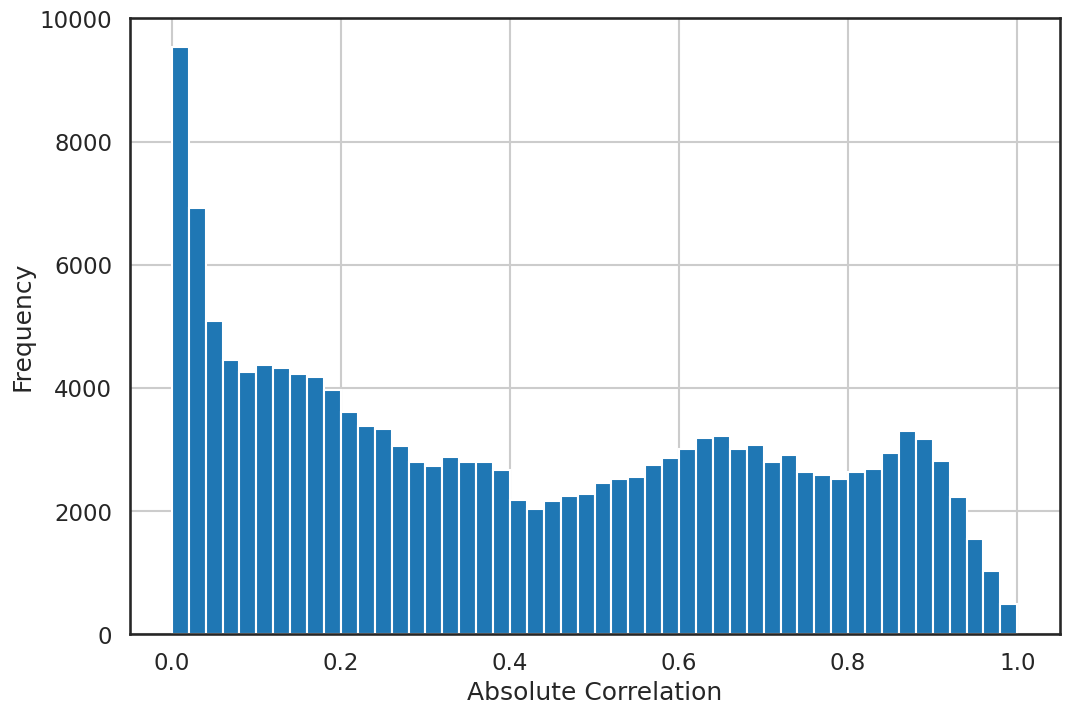

In [13]:
# Visualize the correlations
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency')
plt.show()

In [14]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
156556,fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
96366,tBodyAccMag-arCoeff()4,tGravityAccMag-arCoeff()4,1.000000,1.000000
109498,tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-sma(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [15]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,
                                          test_size=0.3,
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [16]:
# Proportion of diffrent values in train set
y_train.value_counts(normalize=True)

,proportion
Activity,
0,0.188792
2,0.185046
1,0.172562
3,0.167152
5,0.149951
4,0.136496


In [17]:
# Proportion of different values in test set
y_test.value_counts(normalize=True)
### END SOLUTION

,proportion
Activity,
0,0.188673
2,0.185113
1,0.172492
3,0.167314
5,0.149838
4,0.136570


## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [18]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [19]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [20]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

## Question 5

* Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.


In [21]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
329 -0.012531  0.173405  0.121301  0.087804 -0.201137  0.019096  0.000000   
481  0.005824  0.268991  0.249513  0.133512  0.030611  0.638795  0.000000   
361 -0.029097  0.061203 -0.048400 -0.058915 -0.051001 -0.288638  0.000000   
521 -0.025274  0.099147 -0.002325  0.001622  0.132813 -0.435023 -0.020011   
193 -0.029849  0.902269 -0.846995 -1.016444 -0.625240  1.617627  0.000000   
377 -0.077703  0.370909 -0.381862  0.586207 -0.407835 -0.357296  0.000000   
455  0.375687  0.494908 -0.287333 -0.004278  0.381322  0.089570  0.245136   
452  0.378647 -0.409949  0.416460  0.059008 -0.328556 -0.409327  0.946601   
398 -0.012117  0.184953  0.200984  0.156291 -0.173779  0.117448 -0.106971   
198 -0.120069  0.076024 -0.172307  1.735218  0.377467 -2.234887  0.000000   

                                                             l2            \
            1         2         3         4         5         0         1   
329  0.000000  0.000000  0.000000 -0.010921  0.000000 -0.039497  0.705097   
481  0.487517  0.342105  0.000000  0.080330  0.562175 -0.010856  0.854216   
361  0.000000  0.000000  0.000000 -0.026254 -0.227668 -0.067628  0.038042   
521  0.000000  0.000000  0.000000  0.235560 -0.519085 -0.062100  0.234960   
193  1.823265 -2.047638 -2.857320 -1.854731  6.379002 -0.090747  4.827597   
377  0.016432  0.000000  0.987674 -2.167935 -1.071582 -0.203678  1.762834   
455  1.060743  0.000000  0.000000  0.765951  0.000000  0.726807  3.069790   
452 -0.352281  0.305625  0.000000 -0.420007 -0.745479  0.712996 -0.399881   
398  0.000000  0.000000  0.006537 -0.146458  0.132991 -0.040859  0.608004   
198  0.113771 -0.410056  3.678515  2.838306 -6.086205 -0.219840  0.150649   

                                             
            2         3         4         5  
329  0.134910  0.067912 -0.486122  0.211195  
481  0.302333  0.263636  0.024331  1.423073  
361 -0.074854 -0.416787 -0.071458 -0.447568  
521 -0.027783  0.273167  0.289705 -0.771160  
193 -1.507667 -2.690339 -1.199014  3.897856  
377 -0.655959  0.949626 -0.782594 -0.594625  
455 -0.613051  0.029057  0.693356  0.070369  
452  0.427632  0.495896 -0.386084 -0.896160  
398  0.285442  0.301203 -0.442234  0.346388  
198 -0.287103  4.852909  1.304646 -4.284723

Prepare six separate plots for each of the multi-class coefficients.


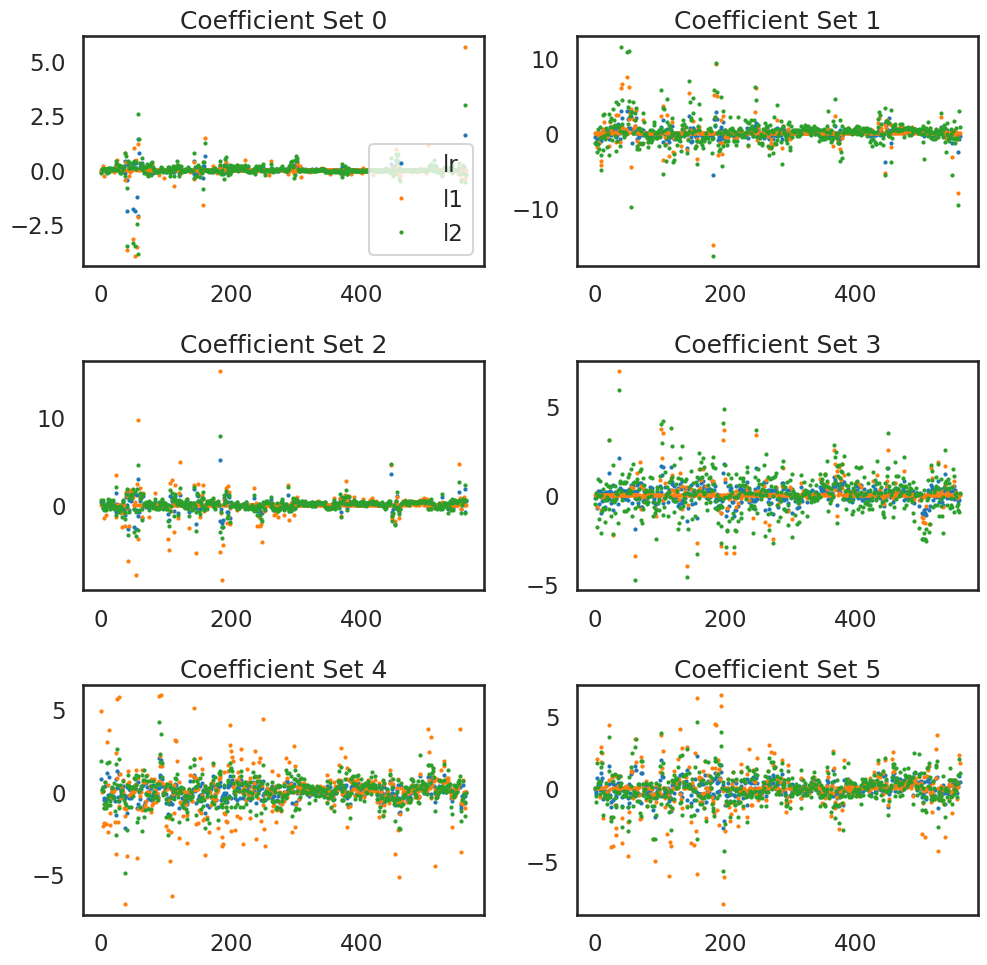

In [22]:
# Visualize coefficient sets
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)

    if ax is axList[0]:
        ax.legend(loc=4)

    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

* Predict and store the class for each model.
* Store the probability for the predicted class for each model.


In [23]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))

y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [24]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.998939,0.998930,0.999757
1,0.988165,0.999836,0.999489
2,0.987592,0.996312,0.999657
3,0.981381,0.999196,0.994339
4,0.998277,0.999919,0.999997


## Question 7

For each model, calculate the following error metrics:

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [25]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')

    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])

    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]),
              average='weighted')

    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc},
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [26]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.984144,0.983514,0.983824
recall,0.984142,0.983495,0.983819
fscore,0.984143,0.983492,0.983819
accuracy,0.984142,0.983495,0.983819
auc,0.990384,0.989949,0.990165


## Question 8

* Display or plot the confusion matrix for each model.


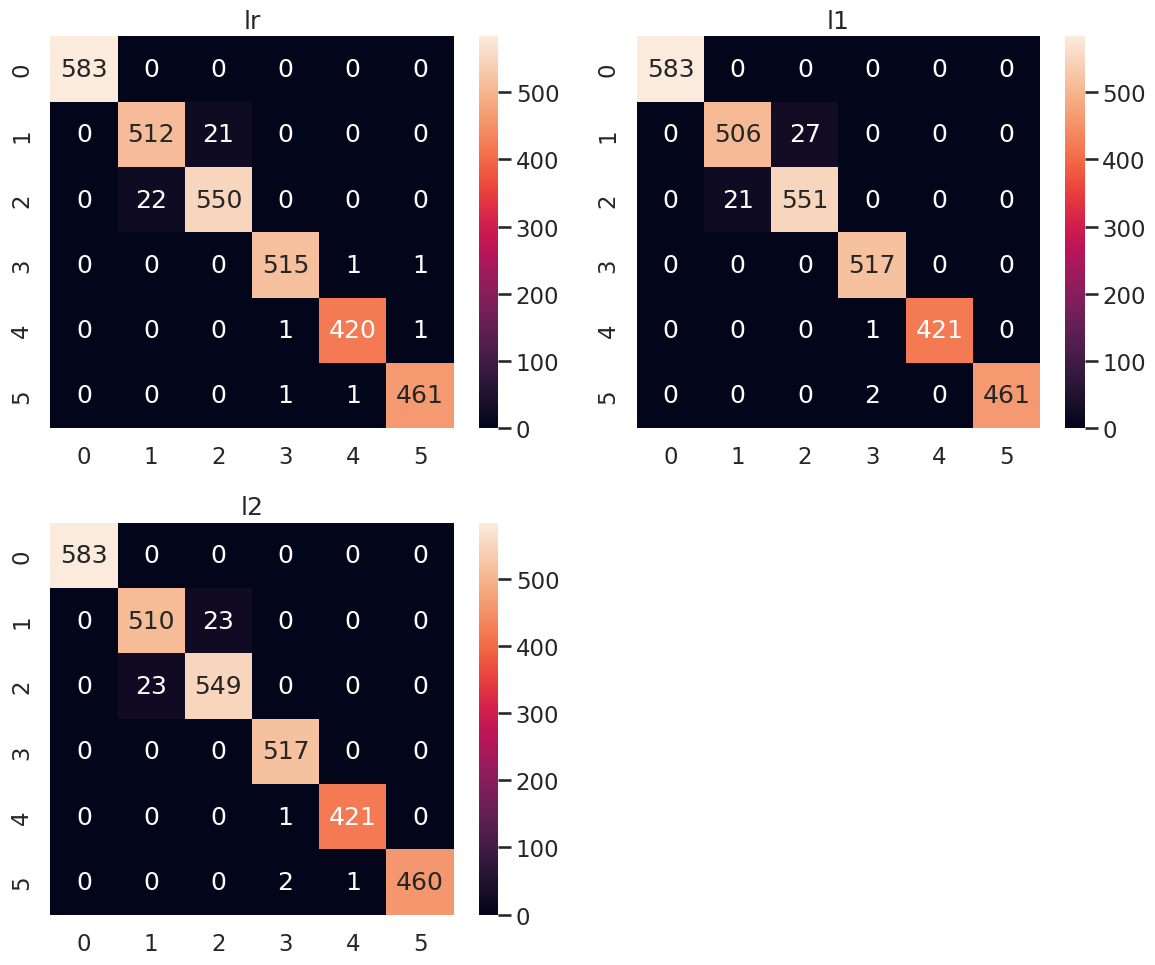

In [27]:
### BEGIN SOLUTION
# Visualize Confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);

plt.tight_layout()
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation
